# Image segmentation for mammograms

### Analysis
- Overview over fields in metadata
- Classes and their distribution
- Example image of each class
- Size of mask pr. class
- Image dimensions

### Dataset
- (?) Extend dataset with similar data such as lung cancer

### Preprocessing
- Crop images to breast
- Normalize pixel values
- Resize
- Embed class to mask (if necessary)
- Remove irrelevant artifacts
- Merge samples of same person


### Models
- U-net
- Transformers
- Mask R-CNN


### Proposed method
1. Downsample images to 224x224 or 512x512
2. Detect ROIs with U-net
3. Cut out ROIs of original image
4. Pass ROI cutouts to a transformer network

### Metrics
- mIoU
- Recall
- Precision
- F1
- AUC
- Dice coefficient

### Postprocessing
- (?) Upscale generated mask to original size
- Calculate bounding boxes of segmentation
- CLAHE

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom as dicom
import re
import numpy as np
import cv2 as cv
import json

# Analysis

In [2]:
metadata = pd.read_csv("metadata.csv")
metadata = metadata[metadata["abnormality_type"] == "mass"]
metadata.pathology = metadata.pathology.apply(lambda x: x.replace("_", " ").capitalize())

train_df = metadata[metadata["dataset"] == "train"].copy()
test_df = metadata[metadata["dataset"] == "test"].copy()

print(f"Training set rows: {len(train_df)}")
print(f"Testing set rows: {len(test_df)}")

metadata.head()

Training set rows: 1318
Testing set rows: 378


,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,shape,margin,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,roi_mask_file_path,dataset,checksum
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,Malignant,4,dataset/train/mass/P_00001_LEFT_CC_1_original.dcm,dataset/train/mass/P_00001_LEFT_CC_1_cropped.dcm,dataset/train/mass/P_00001_LEFT_CC_1_mask.dcm,train,8edd908901f92930776353c9ed140d95
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,Malignant,4,dataset/train/mass/P_00001_LEFT_MLO_1_original...,dataset/train/mass/P_00001_LEFT_MLO_1_cropped.dcm,dataset/train/mass/P_00001_LEFT_MLO_1_mask.dcm,train,d15f9840224eafd79870dc700c2e6cb1
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,Benign,3,dataset/train/mass/P_00004_LEFT_CC_1_original.dcm,dataset/train/mass/P_00004_LEFT_CC_1_cropped.dcm,dataset/train/mass/P_00004_LEFT_CC_1_mask.dcm,train,17b97fe9529c1f9777fbf031fdfe7909
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,Benign,3,dataset/train/mass/P_00004_LEFT_MLO_1_original...,dataset/train/mass/P_00004_LEFT_MLO_1_cropped.dcm,dataset/train/mass/P_00004_LEFT_MLO_1_mask.dcm,train,39a6e98a61aa8e2c19b3136c48e1cc07
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,Benign,5,dataset/train/mass/P_00004_RIGHT_MLO_1_origina...,dataset/train/mass/P_00004_RIGHT_MLO_1_cropped...,dataset/train/mass/P_00004_RIGHT_MLO_1_mask.dcm,train,baf98767e0ca955c78f41c147077435e


Composite key: patient_id, left_or_right_breast, image_view, abnormality_type, pathology

### Variables
https://www.nature.com/articles/sdata2017177
- ```patient_id```: The id of the patient
- ```Breast_density```: https://www.cdc.gov/cancer/breast/basic_info/dense-breasts.htm

    0. Unknown
    1. The breasts are almost entirely fatty (about 10% of women).
    2. A few areas of dense tissue are scattered through the breasts (about 40% of women).
    3. The breasts are evenly dense throughout (about 40% of women).
    4. The breasts are extremely dense (about 10% of women).
<br>
<br>

- ```left_or_right_breast```: Mammogram of left or right breast
- ```image_view```:
    - ```CC```: Craniocaudal view
    - ```MLO```: Mediolateral oblique view
<br>
<br>
- ```abnormality_id```: Id of sepecific segmentation for the same patient
- ```abnormality_type```:
    - ```Mass```: Area of abnormal breast tissue 
    - ```Calcification```: Depots of calcium
<br>
<br>
- ```shape```: Shape of the mass
- ```margin```: Normal tissue surrounding the mass
- ```assessment```: BI-RADS assessment. Actions to be taken based on the analysis
- ```pathology```:
    - Malignant
    - Benign
    - Benign without callback: Worth tracking but without any followup
<br>
<br>
- ```subtlety```: Radiologists’ rating of difficulty in viewing the abnormality in the image
- ```image_file_path```: Path to original image
- ```cropped_image_file_path```: Zoomed in area of the orignal image
- ```roi_mask_file_path```: Segmentation
- ```type```: Type of calcification
- ```distribution```: Distribution of calcification

## Visualizations

In [3]:
palette = sns.color_palette(palette="colorblind")

In [4]:
def create_plot(rows: int = 1, cols: int = 2, figsize: tuple[int, int] = (15, 5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    return fig, axes

def train_test_hist(col: str, train_df: pd.DataFrame = train_df, test_df: pd.DataFrame = test_df, sort_index: bool = False):
    def sub_plot(df: pd.DataFrame, ax, title: str):
        df = df[col].value_counts(normalize=True)
        if sort_index:
            df = df.sort_index()
        
        if df.index.dtype == "object":
            df.index = [re.sub("[_-]", "\n", col).lower() for col in df.index]

        ax = df.plot(kind="bar", rot=0, color=palette, ax=ax, width=0.9)

        for container in ax.containers:
            ax.bar_label(container, fmt="%.4f")
            ax.set_title(title)

    fig, axes = create_plot()

    fig.suptitle(col.replace("_", " ").upper())

    sub_plot(train_df, axes[0], "Training set")
    sub_plot(test_df, axes[1], "Test set")


In [5]:
def plot_pathology(groupby: list[str], title: str, query: str = None, top_n: int = None):
    axes = plt.gca()

    def sub_plot(df: pd.DataFrame, ax, title: str):

        df = df.groupby(groupby).size().unstack()

        df /= df.sum(axis=1).sum()

        df.plot(kind='bar', stacked=True, color=palette, width=0.9, ax=ax, rot=0)
        ax.set_title(title)

        totals = df.sum(axis=1)
        y_offset = totals.max() / 100

        for i, total in enumerate(totals):
            ax.text(i, total + y_offset, f"{total:.4f}", ha='center')

    sub_plot(metadata, ax=axes, title=f"Training set - {title}")

## Full dataset

Text(0.5, 1.0, 'Mass pathology')

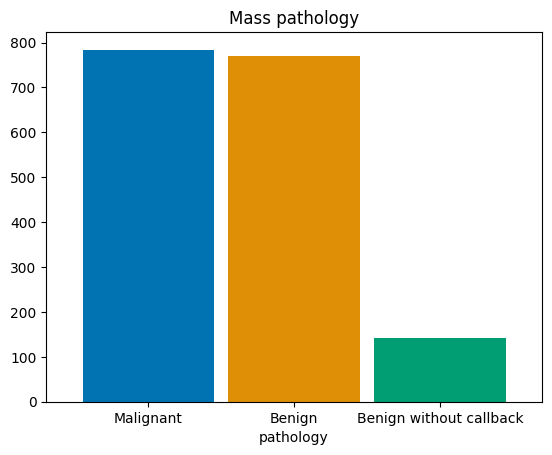

In [6]:
metadata.pathology.value_counts().plot(kind="bar", rot=0, color=palette, width=0.9)
plt.title("Mass pathology")


### Training set vs Test set

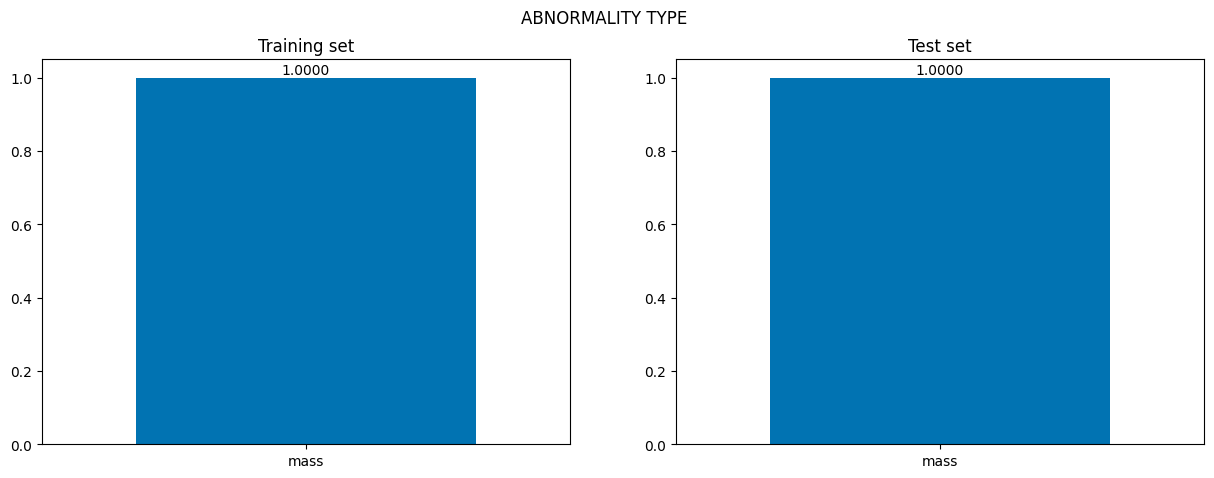

In [7]:
train_test_hist("abnormality_type", sort_index=True)

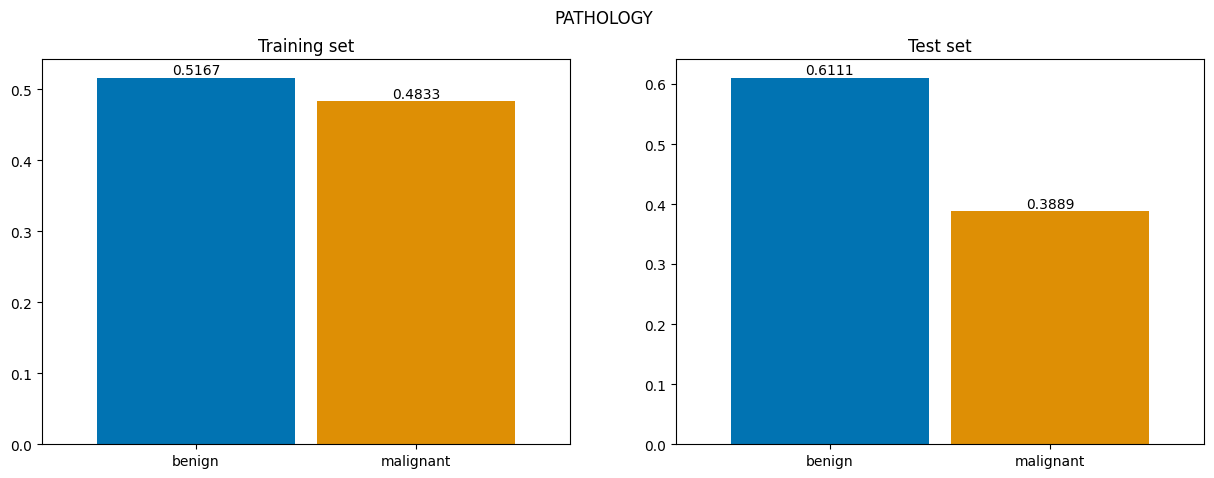

In [8]:
no_bwc_train = train_df.copy()
no_bwc_test = test_df.copy()

no_bwc_train.loc[no_bwc_train["pathology"] == 'Benign without callback', "pathology"] = "Benign"
no_bwc_test.loc[no_bwc_test["pathology"] == 'Benign without callback', "pathology"] = "Benign"

train_test_hist("pathology", train_df=no_bwc_train, test_df=no_bwc_test, sort_index=True)

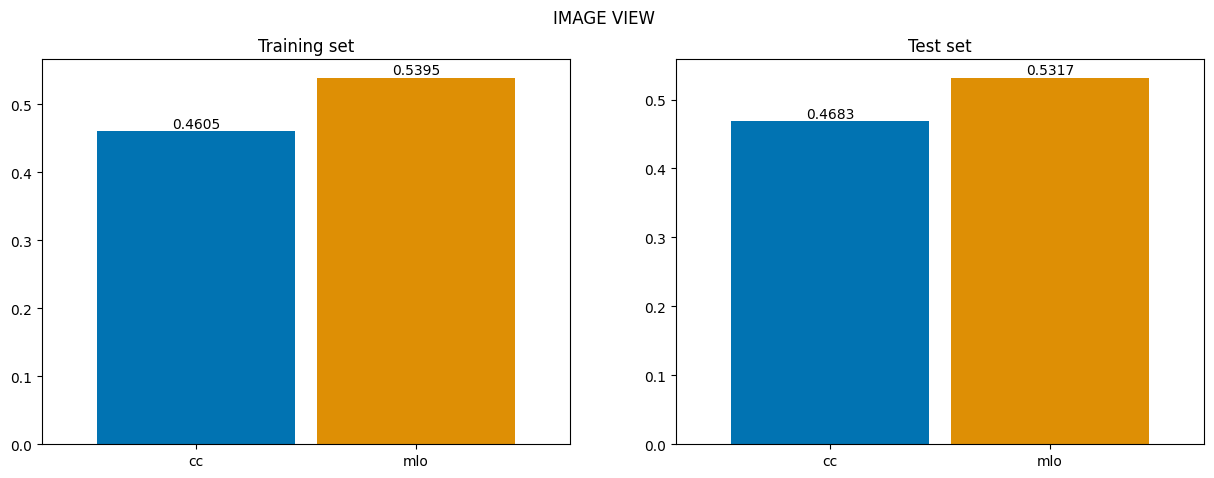

In [9]:
train_test_hist("image_view", sort_index=True)

In [10]:
# train_test_hist("breast_density", sort_index=True)

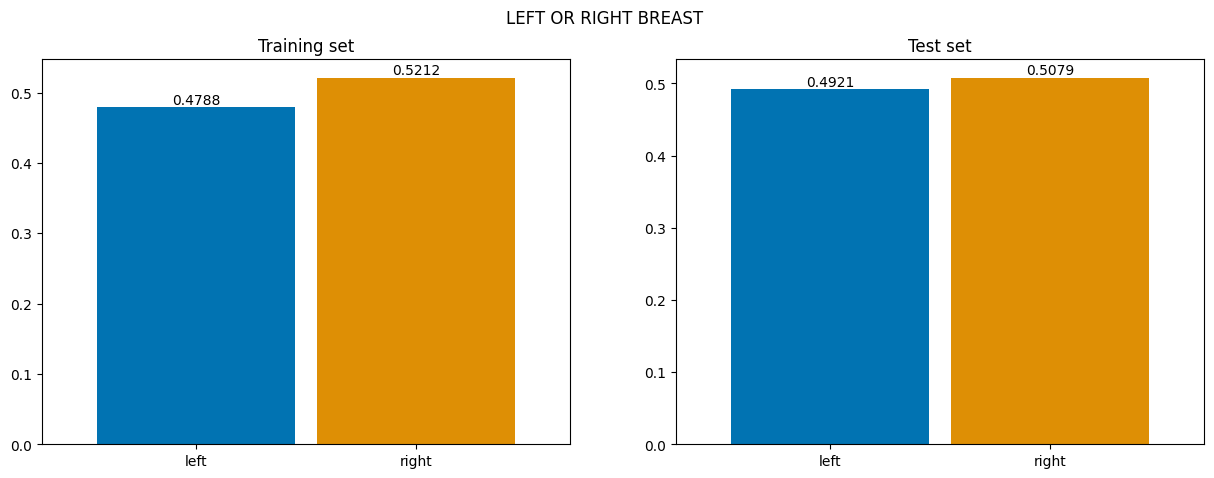

In [11]:
train_test_hist("left_or_right_breast", sort_index=True)

In [12]:
# def plot_abnormality_type(abnormality_type: str, sub_cat: str, top_n: int = 5):
#     fig, axes = create_plot()
    
#     def sub_plot(df: pd.DataFrame, title: str, ax):
#         df = df[df.abnormality_type == abnormality_type][sub_cat].value_counts(normalize=True).to_frame()
#         df.index = [re.sub("[_-]", "\n", col).lower() for col in df.index]

#         ax = df[sub_cat].iloc[:top_n].plot(kind="bar", color=palette, ax=ax, rot=0, width=0.9)
#         ax.bar_label(ax.containers[0], fmt="%.4f")
#         ax.set_title(f"{title} - {abnormality_type} {sub_cat}")

#     sub_plot(train_df, "Training set", ax=axes[0])
#     sub_plot(test_df, "Test set", ax=axes[1])

# plot_abnormality_type(abnormality_type="mass", sub_cat="shape")
# plot_abnormality_type(abnormality_type="mass", sub_cat="margin")

In [13]:
# plot_abnormality_type(abnormality_type="calcification", sub_cat="type")
# plot_abnormality_type(abnormality_type="calcification", sub_cat="distribution")

In [14]:
# https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/mammograms/understanding-your-mammogram-report.html
# train_test_hist("assessment", sort_index=True)

### Pathology

In [15]:
def plot_pathology(groupby: list[str], title: str, query: str = None, top_n: int = None, train_df: pd.DataFrame = train_df, test_df: pd.DataFrame = test_df):
    fig, axes = create_plot()

    def sub_plot(df: pd.DataFrame, ax, title: str):
        if query is not None:
            df = df.query(query)

        df = df.groupby(groupby)

        df = df.size().unstack()

        if df.columns.dtype == "object":
            df.columns = [re.sub("[_-]", " ", col).lower() for col in df.columns]

        if df.index.dtype == "object":
            df.index = [re.sub("[_-]", "\n", col).lower() for col in df.index]

        if top_n is not None:
            df_sum = df.sum(axis=1)
            indexes = df_sum.sort_values(ascending=False).index[:top_n]
            df = df.query("index in @indexes")

        df /= df.sum(axis=1).sum()

        df.plot(kind='bar', stacked=True, color=palette, width=0.9, ax=ax, rot=0)
        ax.set_title(title)

        totals = df.sum(axis=1)
        y_offset = totals.max() / 100

        for i, total in enumerate(totals):
            ax.text(i, total + y_offset, f"{total:.4f}", ha='center')

    sub_plot(train_df, ax=axes[0], title=f"Training set - {title}")
    sub_plot(test_df, ax=axes[1], title=f"Test set - {title}")

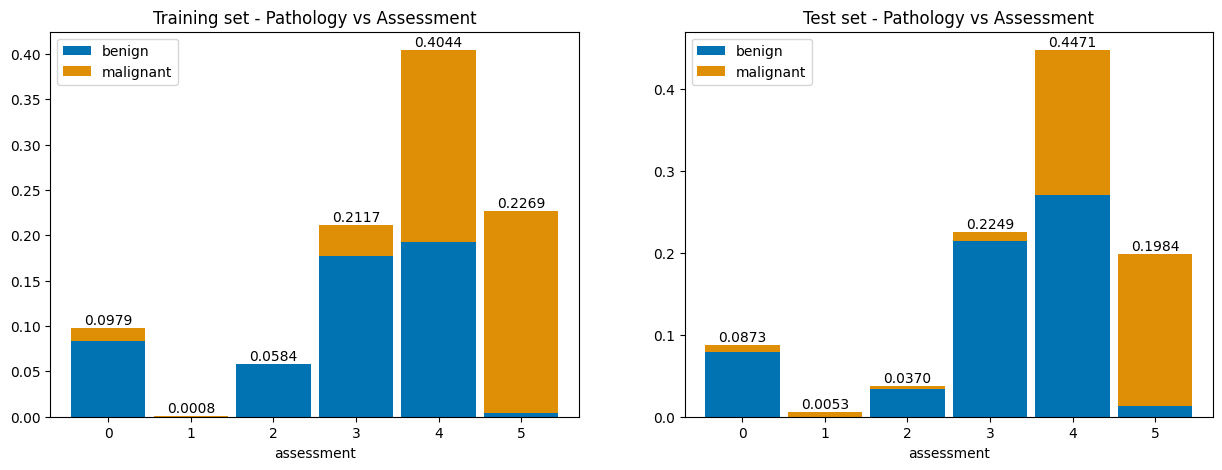

In [16]:
plot_pathology(["assessment", "pathology"], title="Pathology vs Assessment", train_df=no_bwc_train, test_df=no_bwc_test)

['IRREGULAR-ARCHITECTURAL_DISTORTION' 'ARCHITECTURAL_DISTORTION' 'OVAL'
 'IRREGULAR' 'LYMPH_NODE' 'LOBULATED-LYMPH_NODE' 'LOBULATED'
 'FOCAL_ASYMMETRIC_DENSITY' 'ROUND' 'LOBULATED-ARCHITECTURAL_DISTORTION'
 'ASYMMETRIC_BREAST_TISSUE' 'LOBULATED-IRREGULAR' nan 'OVAL-LYMPH_NODE'
 'LOBULATED-OVAL' 'ROUND-OVAL' 'IRREGULAR-FOCAL_ASYMMETRIC_DENSITY'
 'ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION' 'ROUND-LOBULATED']


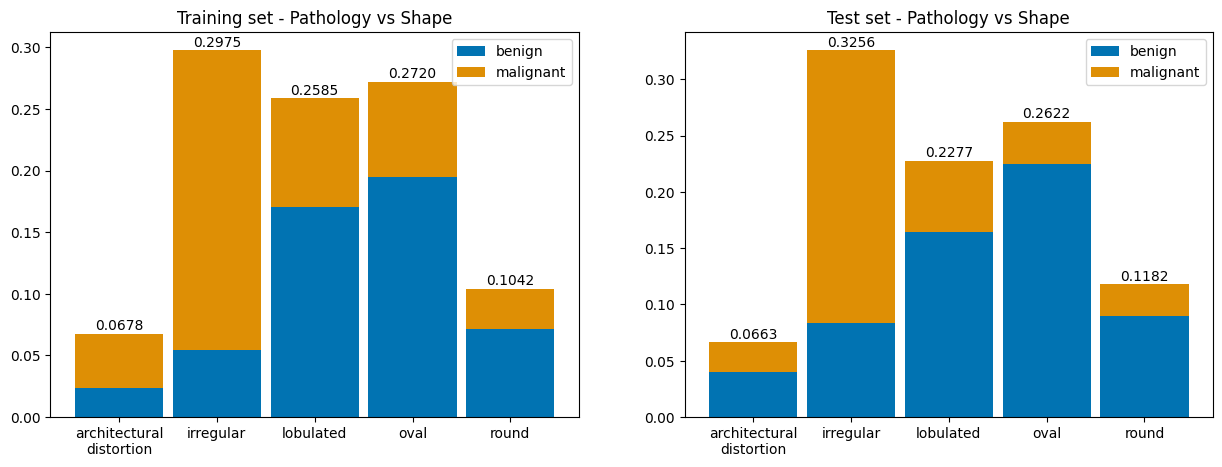

In [17]:
print(no_bwc_train["shape"].unique())
plot_pathology(["shape", "pathology"], query="abnormality_type == 'mass'", title="Pathology vs Shape", top_n=5, train_df=no_bwc_train, test_df=no_bwc_test)

['SPICULATED' 'ILL_DEFINED' 'CIRCUMSCRIBED' 'ILL_DEFINED-SPICULATED'
 'OBSCURED' 'OBSCURED-ILL_DEFINED' nan 'MICROLOBULATED'
 'MICROLOBULATED-ILL_DEFINED-SPICULATED' 'MICROLOBULATED-SPICULATED'
 'CIRCUMSCRIBED-ILL_DEFINED' 'MICROLOBULATED-ILL_DEFINED'
 'CIRCUMSCRIBED-OBSCURED' 'OBSCURED-SPICULATED'
 'OBSCURED-ILL_DEFINED-SPICULATED' 'CIRCUMSCRIBED-MICROLOBULATED']


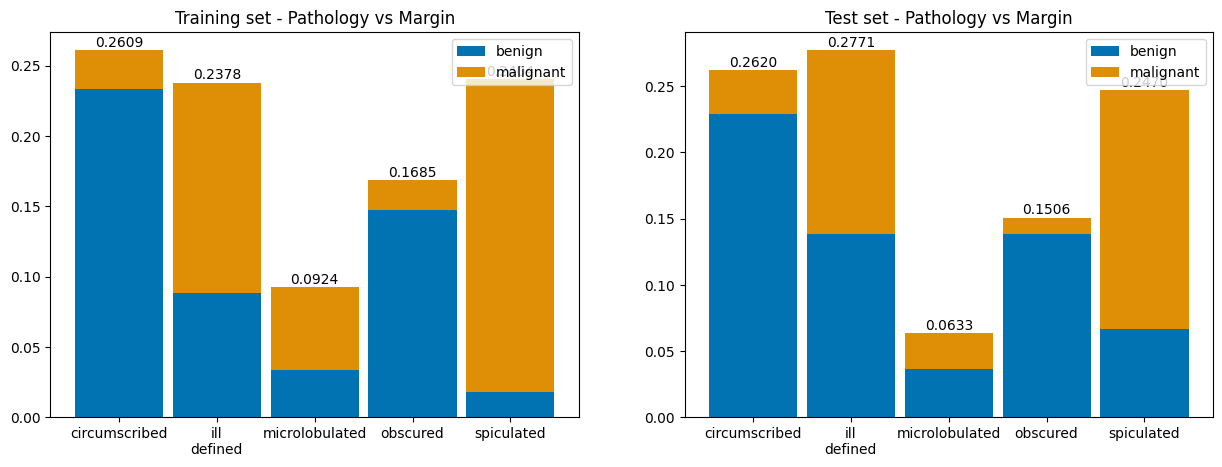

In [50]:
print(no_bwc_train["margin"].unique())
plot_pathology(["margin", "pathology"], query="abnormality_type == 'mass'", title="Pathology vs Margin", top_n=5, train_df=no_bwc_train, test_df=no_bwc_test)

In [18]:
margins = ["CIRCUMSCRIBED", "ILL_DEFINED", "MICROLOBULATED", "OBSCURED", "SPICULATED"]
plot_pathology(["margin", "shape"], query="abnormality_type == 'mass'", title="Pathology vs Margin", top_n=5, train_df=no_bwc_train.query("shape in @shapes and margin in @margins"), test_df=no_bwc_test.query("shape in @shapes and margin in @margins"))

UndefinedVariableError: local variable 'shapes' is not defined

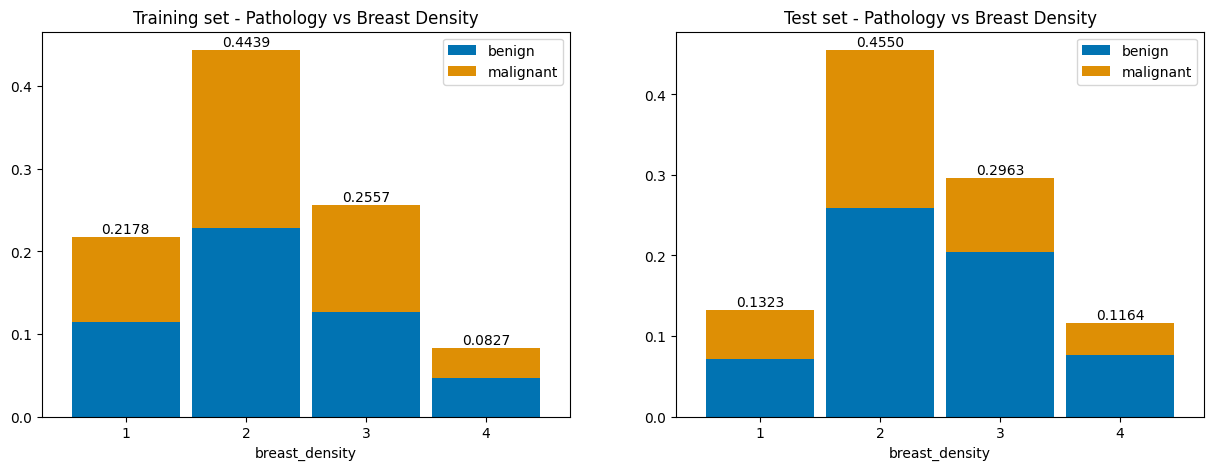

In [19]:
plot_pathology(["breast_density", "pathology"], title="Pathology vs Breast Density", train_df=no_bwc_train, test_df=no_bwc_test)

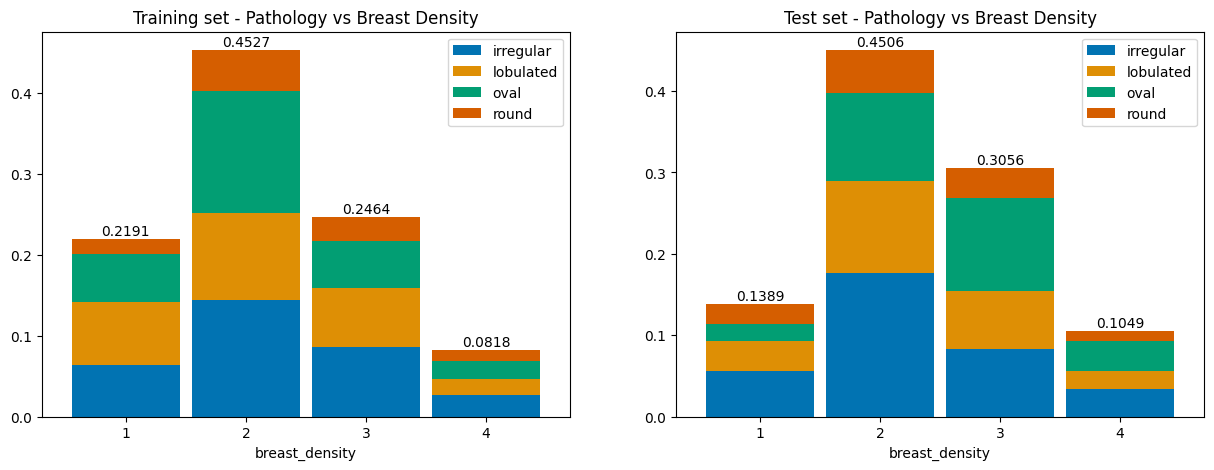

In [20]:
shapes = ['OVAL', 'ROUND', 'IRREGULAR', 'LOBULATED']
plot_pathology(["breast_density", "shape"], title="Pathology vs Breast Density", train_df=no_bwc_train.query("shape in @shapes"), test_df=no_bwc_test.query("shape in @shapes"))

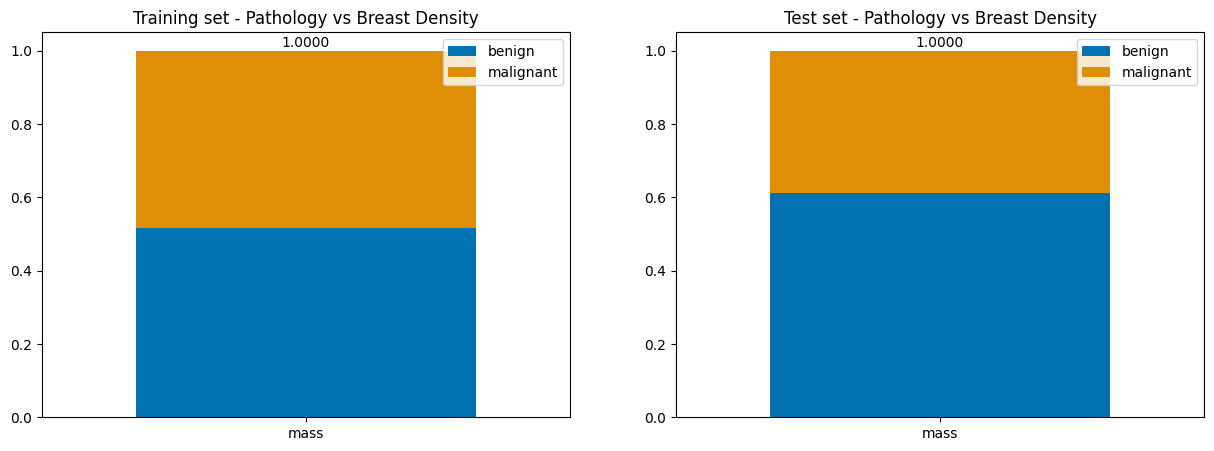

In [21]:
plot_pathology(["abnormality_type", "pathology"], title="Pathology vs Breast Density", train_df=no_bwc_train, test_df=no_bwc_test)

[Text(0.5, 0, 'Amount of different segmentations for same image')]

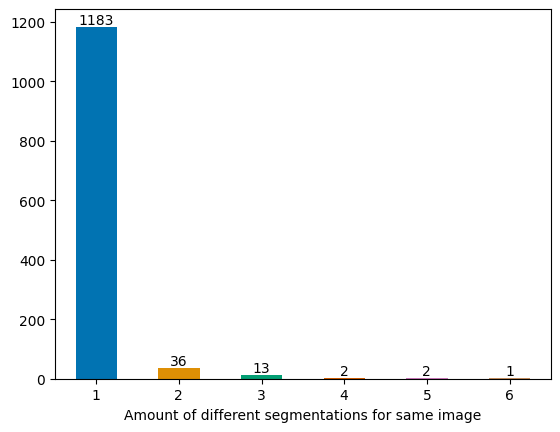

In [22]:
# df = train_df.groupby(["patient_id", "left_or_right_breast", "image_view", "abnormality_type", "pathology"]).abnormality_id.max().value_counts().to_frame("amount").reset_index()

# ax = sns.barplot(data=df, x="index", y="amount")

ax = no_bwc_train.groupby(["patient_id", "left_or_right_breast", "image_view", "abnormality_type", "pathology"]).size().value_counts().plot(kind="bar", color=palette, rot=0)
ax.bar_label(ax.containers[0])
ax.set(xlabel="Amount of different segmentations for same image")

[Text(0.5, 0, 'Amount of different segmentations for same image')]

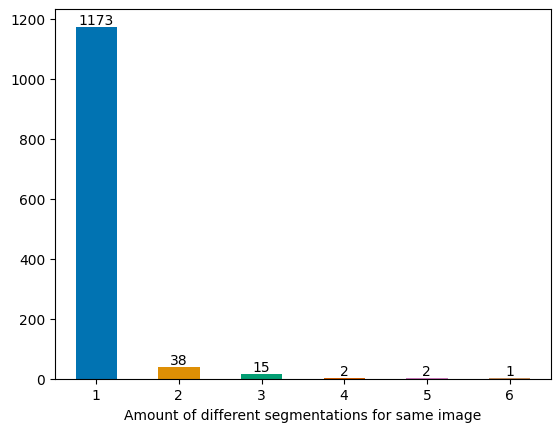

In [23]:
ax = no_bwc_train.groupby(["checksum"]).size().value_counts().plot(kind="bar", color=palette, rot=0)
ax.bar_label(ax.containers[0])
ax.set(xlabel="Amount of different segmentations for same image")

In [24]:
train_df.groupby(["patient_id", "left_or_right_breast", "image_view", "abnormality_type", "pathology"]).size().to_frame("amount").reset_index().value_counts()

patient_id  left_or_right_breast  image_view  abnormality_type  pathology  amount
P_00001     LEFT                  CC          mass              Malignant  1         1
P_01268     RIGHT                 CC          mass              Benign     1         1
P_01271     RIGHT                 MLO         mass              Benign     1         1
                                  CC          mass              Benign     1         1
P_01270     RIGHT                 MLO         mass              Malignant  2         1
                                                                                    ..
P_00651     RIGHT                 MLO         mass              Benign     1         1
P_00648     LEFT                  MLO         mass              Malignant  1         1
                                  CC          mass              Malignant  1         1
P_00644     LEFT                  MLO         mass              Malignant  1         1
P_02092     LEFT                  MLO         ma

### Area visualization

In [25]:
preprocessed_metadata = pd.read_csv("./preprocessed_metadata.csv")
preprocessed_metadata = preprocessed_metadata.query("abnormality_type == 'mass'")
preprocessed_metadata.bounding_boxes = preprocessed_metadata.bounding_boxes.apply(json.loads)

preprocessed_metadata.head()

,Unnamed: 0,index,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,shape,margin,...,checksum,is_flipped,vertical_crop_pixels,horizontal_crop_pixels,width,height,preprocessed_original_image_path,num_masks,bounding_boxes,preprocessed_mass_all_mask_path
0,0,0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,...,8edd908901f92930776353c9ed140d95,False,480,1918,1918,3848,./dataset/preprocessed/8edd908901f92930776353c...,1,"[{'x': 270, 'y': 1942, 'width': 390, 'height':...",./dataset/preprocessed/8edd908901f92930776353c...
1,1,1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,...,d15f9840224eafd79870dc700c2e6cb1,False,480,2138,2138,3840,./dataset/preprocessed/d15f9840224eafd79870dc7...,1,"[{'x': 271, 'y': 2500, 'width': 215, 'height':...",./dataset/preprocessed/d15f9840224eafd79870dc7...
2,2,2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,...,17b97fe9529c1f9777fbf031fdfe7909,True,549,2277,2277,4393,./dataset/preprocessed/17b97fe9529c1f9777fbf03...,1,"[{'x': 1186, 'y': 2951, 'width': 382, 'height'...",./dataset/preprocessed/17b97fe9529c1f9777fbf03...
3,3,3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,...,39a6e98a61aa8e2c19b3136c48e1cc07,True,549,2151,2151,4393,./dataset/preprocessed/39a6e98a61aa8e2c19b3136...,1,"[{'x': 1011, 'y': 2506, 'width': 381, 'height'...",./dataset/preprocessed/39a6e98a61aa8e2c19b3136...
4,4,4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,...,baf98767e0ca955c78f41c147077435e,False,549,2113,2113,4393,./dataset/preprocessed/baf98767e0ca955c78f41c1...,1,"[{'x': 694, 'y': 3255, 'width': 424, 'height':...",./dataset/preprocessed/baf98767e0ca955c78f41c1...


In [47]:
bbox_df = pd.DataFrame()

for i, row in preprocessed_metadata.iterrows():
    bboxes = pd.DataFrame.from_dict(row.bounding_boxes)
    bboxes["org_width"] = row.width
    bboxes["org_height"] = row.height
    bbox_df = pd.concat([bbox_df, bboxes])

# bbox_df.x = bbox_df.apply(lambda row: row.x / row.org_width, axis=1)
# bbox_df.y = bbox_df.apply(lambda row: row.y / row.org_height, axis=1)
# bbox_df.width = bbox_df.apply(lambda row: row.width / row.org_width, axis=1)
# bbox_df.height = bbox_df.apply(lambda row: row.height / row.org_height, axis=1)

bbox_df.head()

,x,y,width,height,type,unaligned,label,shape,margin,assessment,subtlety,mask_path,org_width,org_height
0,270,1942,390,474,mass,False,MALIGNANT,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,4,./dataset/preprocessed/8edd908901f92930776353c...,1918,3848
0,271,2500,215,251,mass,False,MALIGNANT,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,4,./dataset/preprocessed/d15f9840224eafd79870dc7...,2138,3840
0,1186,2951,382,425,mass,False,BENIGN,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,3,./dataset/preprocessed/17b97fe9529c1f9777fbf03...,2277,4393
0,1011,2506,381,386,mass,False,BENIGN,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,3,./dataset/preprocessed/39a6e98a61aa8e2c19b3136...,2151,4393
0,694,3255,424,358,mass,False,BENIGN,OVAL,CIRCUMSCRIBED,4,5,./dataset/preprocessed/baf98767e0ca955c78f41c1...,2113,4393


<Axes: xlabel='x', ylabel='y'>

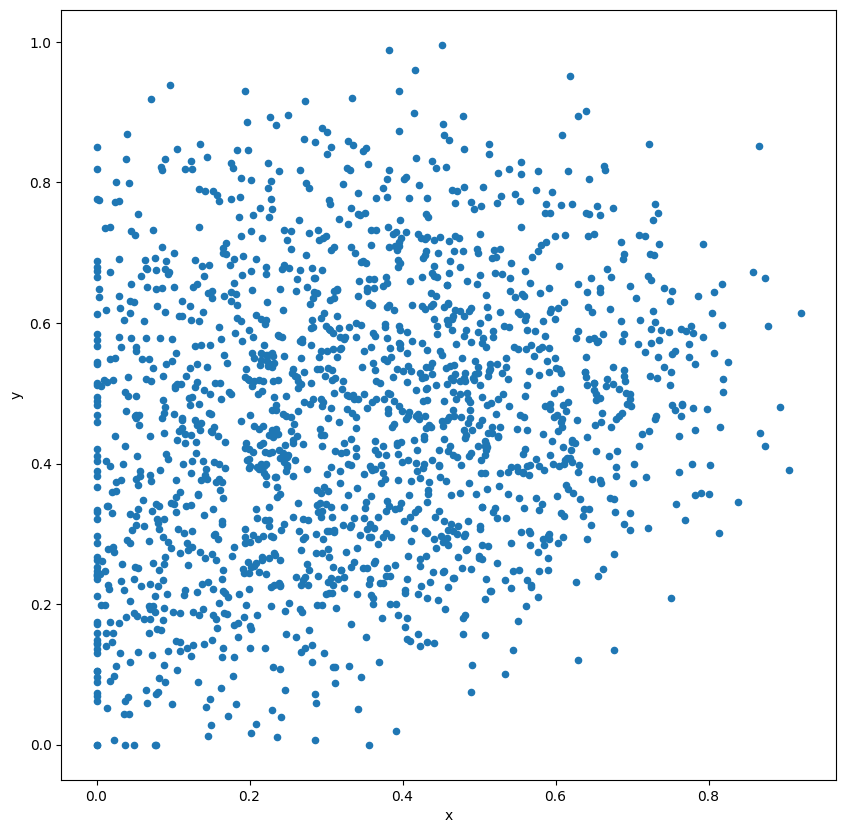

In [45]:
bbox_df.plot.scatter(x="x", y="y", figsize=(10, 10))

Text(0, 0.5, 'Height in pixels')

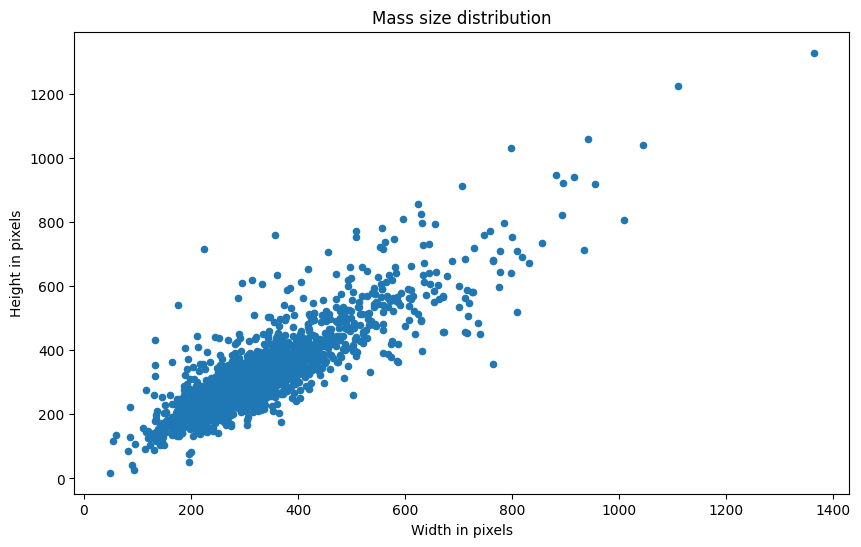

In [49]:
ax = bbox_df.plot.scatter(x="width", y="height", figsize=(10, 6))
ax.set_title("Mass size distribution")
ax.set_xlabel("Width in pixels")
ax.set_ylabel("Height in pixels")

## Visualize examples

In [ ]:
def show_mammogram_examples(df: pd.DataFrame, title: str):
    amount = len(df)

    for i in range(amount):
        sample = df.iloc[i]

        img_original_path = sample['image_file_path']
        img_cropped_path = sample['cropped_image_file_path']
        img_roi_path = sample['roi_mask_file_path']

        img_original = dicom.dcmread(img_original_path)
        img_roi = dicom.dcmread(img_roi_path)
        img_cropped = dicom.dcmread(img_cropped_path)
        plt.suptitle(title, fontsize=25, y=0.95)
        plt.subplot(amount, 3, i * 3 + 1)
        plt.title(f"{sample['abnormality_type']} mammogram".upper())
        plt.imshow(img_original.pixel_array)
        plt.subplot(amount, 3, i * 3 + 2)
        plt.title("SEGMENTATION")
        plt.imshow(img_roi.pixel_array)
        plt.subplot(amount, 3, i * 3 + 3)
        plt.title("ZOOMED IN AREA")
        plt.imshow(img_cropped.pixel_array)
    
    plt.gcf().set_size_inches(10, 12)
    plt.show()

In [ ]:
for pathology_type in train_df.pathology.unique():
    sub_df = metadata[metadata["pathology"] == pathology_type.upper()]

    show_mammogram_examples(sub_df.loc[metadata["abnormality_type"] == "mass"], f"Mass {pathology_type}")
    show_mammogram_examples(sub_df.loc[metadata["abnormality_type"] == "calcification"], f"Calcification {pathology_type}")

: 

: 

In [ ]:
df = train_df.groupby(["patient_id", "left_or_right_breast", "image_view", "pathology"]).size().to_frame("amount").reset_index()
patient_id = df.query("amount > 2").iloc[0].patient_id

df = train_df.query("patient_id == @patient_id and image_view == 'MLO' and left_or_right_breast == 'LEFT'")
title = df.abnormality_type.iloc[0].upper() + " " + df.pathology.iloc[0]
show_mammogram_examples(df, title, amount=len(df))
df[["patient_id", "left_or_right_breast", "image_view", "abnormality_id", "pathology", "image_file_path", "cropped_image_file_path", "roi_mask_file_path"]]

In [ ]:
train_df[train_df["patient_id"] == "P_00112"]

In [ ]:
patient_id_mass = train_df.query("abnormality_type == 'mass'").patient_id.to_list()

train_df.query("abnormality_type == 'calcification' and patient_id in @patient_id_mass")

In [ ]:
df = train_df.query("patient_id == 'P_00208' and left_or_right_breast == 'RIGHT' and image_view == 'MLO'")
show_mammogram_examples(df, "Test")
df

# Preprocessing
- Unify direction
- Find contours
- Mask image
- Crop image

Find contours

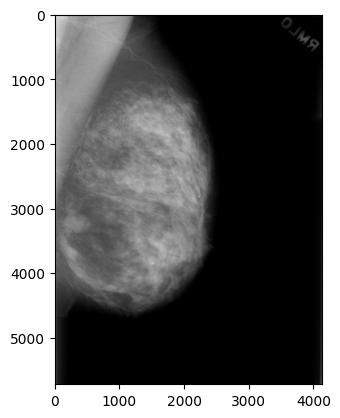

In [ ]:
def get_largest_contour(contours: list):
    largest_contour = contours[0]

    for con in contours:
        if len(con) > len(largest_contour):
            largest_contour = con

    return largest_contour

CROP_SIZE = 400

df = train_df.query("patient_id == 'P_00208' and left_or_right_breast == 'RIGHT' and image_view == 'MLO'")

sample = df.iloc[0]

image_path = sample.image_file_path

pixel_array = dicom.dcmread(image_path).pixel_array

# Flip image
center = pixel_array.shape[1] // 2
left_side = pixel_array[:, :center].sum()
right_side = pixel_array[:, center:].sum()
is_flipped = False

if left_side < right_side:
    pixel_array = np.fliplr(pixel_array)
    is_flipped = True

plt.imshow(pixel_array, cmap="gray")

20.35 MP


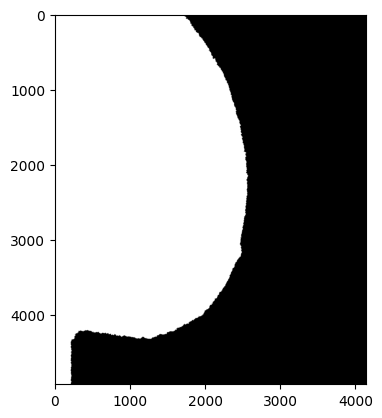

In [ ]:
# TODO remove large blobs on edges

pixel_array_cropped = pixel_array[CROP_SIZE:-CROP_SIZE].astype(np.uint8)
mp = (pixel_array_cropped.shape[0] * pixel_array_cropped.shape[1]) / 1_000_000
print(f"{mp:.2f} MP")

ret, thresh = cv.threshold(pixel_array_cropped, 100, 255, 0)
contours, hierarchy = cv.findContours(thresh, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)

largest_contour = get_largest_contour(contours)

img = cv.drawContours(np.zeros(shape=pixel_array_cropped.shape), largest_contour, -1, (255), thickness=10)
plt.imshow(cv.fillPoly(img, [largest_contour], color=(255)), cmap="gray")

Find largest contour

In [ ]:
biggest_x = 0

for point in largest_contour:
    x = point[0][0]
    y = point[0][1]
    if x > biggest_x:
        biggest_x = x

biggest_x

2564

Mask image

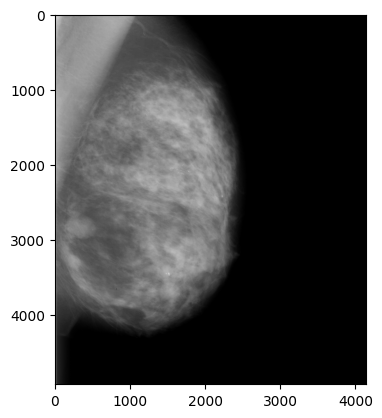

In [ ]:
mask = cv.fillPoly(img, [largest_contour], color=(255))

masked_img = pixel_array[CROP_SIZE:-CROP_SIZE] & np.round((mask / 255) * (2**16 - 1)).astype(np.uint16)

plt.imshow(masked_img, cmap="gray")

Crop image

2564
12.61 MP


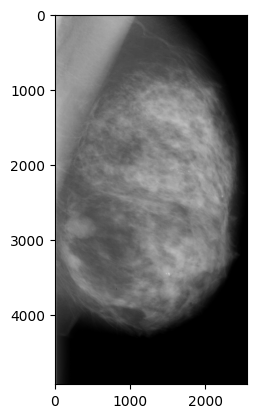

In [ ]:
cropped_img = masked_img[:, :biggest_x]
print(biggest_x)
plt.imshow(cropped_img, cmap="gray")
mp = (cropped_img.shape[0] * cropped_img.shape[1]) / 1_000_000
print(f"{mp:.2f} MP")

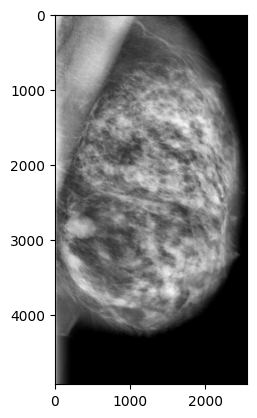

In [ ]:
clahe = cv.createCLAHE(clipLimit=50.0, tileGridSize=(10,10))
cl_img = clahe.apply(cropped_img)

plt.imshow(cl_img, cmap="gray")

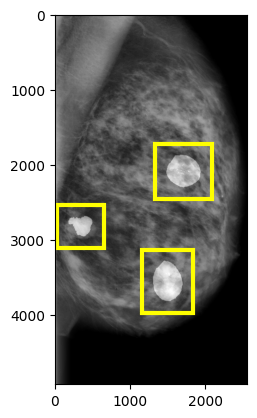

In [ ]:
import matplotlib.patches as patches

def get_segmentations(df: pd.DataFrame):
    result = []
    for i, sample in df.iterrows():
        segmentation = dicom.dcmread(sample.roi_mask_file_path).pixel_array

        if is_flipped:
            segmentation = np.fliplr(segmentation)

        segmentation = segmentation[CROP_SIZE:-CROP_SIZE]
        cropped_segmentation = segmentation[:, :biggest_x]
        result.append(cropped_segmentation)
    
    return result
        
masks = get_segmentations(df)

image_with_masks = cl_img.copy().astype(np.float64)
image_with_masks /= 2**16 - 1

fig, ax = plt.subplots()

offset = 150

bounding_boxes = []

for mask in masks:
    mask = mask.astype(np.float64)
    mask /= 255
    mask *= 0.5
    image_with_masks += mask
    ax.imshow(image_with_masks, cmap="gray")
    a = np.where(mask != 0)
    bbox = np.min(a[1]) - offset, np.min(a[0]) - offset, np.max(a[1]) + offset, np.max(a[0]) + offset
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=3, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)
    bounding_boxes.append(bbox)


plt.show()

(26, 2533, 648, 3108)


/tmp/ipykernel_8735/4025798794.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, i + 1).imshow(masks[i][bbox[1]:bbox[3], bbox[0]:bbox[2]], cmap="gray")


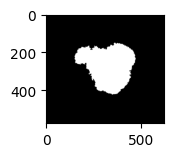

In [ ]:
plt.subplots(1, 3)

for i, bbox in enumerate(bounding_boxes):
    print(bbox)
    plt.subplot(3, 1, i + 1).imshow(masks[i][bbox[1]:bbox[3], bbox[0]:bbox[2]], cmap="gray")
    break